# Fiba Europe 

## Part 4 - Machine Learning Algorithms


The following steps will be performed:

* **4.1** Load the training set, and perform some final bits of data cleanup
* **4.2** Define the algorithm creation functions, and create three sets of algs for predicting the winner of a match using different combinations of features (I will not do any alg tuning here)
* **4.3** Test the algs against the test set and compare results




### 4.1 - Load training set and Perform Cleanup


In practice, I selected my training and test sets by querying the `fiba_europe_games_master` and `fiba_europe_game_xref` tables in a postgres sql database (as referred to in [Part 3](fiba_part3_finding_additional_metadata.ipynb)
). Of the roughly 40,000 adult male matches, I randomly selected 35,000 to serve as the training set, leaving 5,000 as a test set.

### Important Note

"Time", namely the current period of the match and the minutes remaining in the period, is unsuprisingly the most important feature (i.e. highly correlated with prediction accuracy) in the dataset. The closer we are to the end of the match, the easier it is to predict the winner, given the play-by-play stats we have at hand. 

For this analysis I have **split out time completely** when creating the algs. By this I mean, each algorithm  will predict an outcome for a given period and minutes remaining in the period. One could include time as a feature, and make one alg that predicts outcomes at any given moment, but I have not done so here. One alg for each period and minute.

For the purposes of this write-up, I have included two files with the known data at period 1, 3 minutes remaining in period, for 1000 adult male matches in each file:
* `fiba_europe_example/sample_training_data_male_adult_p1m3_slice.pickle`
* `fiba_europe_example/sample_test_data_male_adult_p1m3_slice.pickle`


In [1]:
import  pickle
import os
import pandas as pd

df_train = pd.read_pickle('fiba_europe_example/sample_training_data_male_adult_p1m3_slice.pickle')
print("Length: " + str(len(df_train)))
print("Unique Matches: " + str(len(df_train.match_id.unique())))
df_train.head()


Length: 1000
Unique Matches: 1000


,match_id,row_number,period,minutes_remaining_in_period,current_score_hometeam,current_score_awayteam,ending_score_period1_hometeam,ending_score_period1_awayteam,ending_score_period2_hometeam,ending_score_period2_awayteam,...,free_throw_shots_made_awayteam,free_throw_shots_missed_awayteam,schedule_date,match_location,league_sex,league_age,current_score_hometeam_max,current_score_awayteam_max,minute_row_count,rnk
0,108277,51,1,3,18.0,7.0,24.0,16.0,27.0,34.0,...,2,0,NaT,None,male,adult,58.0,65.0,6,3.0
1,108502,57,1,3,13.0,15.0,25.0,20.0,43.0,44.0,...,2,2,NaT,None,male,adult,78.0,80.0,7,4.0
2,1148,47,1,3,10.0,16.0,14.0,21.0,29.0,44.0,...,1,1,2008-12-16,Tartu (EST),male,adult,58.0,80.0,5,2.0
3,1149,46,1,3,10.0,12.0,13.0,24.0,31.0,40.0,...,2,0,2009-01-06,Tallinn (EST),male,adult,82.0,76.0,12,6.0
4,1161,50,1,3,10.0,12.0,18.0,18.0,38.0,36.0,...,1,0,2009-03-03,Perm (RUS),male,adult,83.0,57.0,4,2.0


In [40]:
"""
Since algs will be created for a given period/minute, the training and test sets 
should be filtered down to a set of matches with all known cumulative info up to that 
period/minute.

For example, if we are predicting for period 1, 1 minutes remaining in period, 
the training set would be 200 lines, each representing what was known at period 1, 
1 minute remaining for a given match

In this case, the data is already in the desired "sliced" format, so this function will not
do anything, but I'll leave it in here just the same
"""

def create_game_minute_slice(df,period,minutes_remaining_in_period):

    # Get rows that match the period and minute remaining we want
    df_slice = df.drop(df[(df.period != period) | (df.minutes_remaining_in_period != minutes_remaining_in_period)].index)
        
    df_slice_counts = df_slice.groupby(['match_id','period','minutes_remaining_in_period']).size()
    df_slice_counts.name = 'minute_row_count'
    df_slice = df_slice.join(df_slice_counts,on=['match_id','period','minutes_remaining_in_period'])
    df_slice['rnk']  = df_slice.groupby(['match_id','period','minutes_remaining_in_period'])['row_number'].rank(method='dense')
    
    df_slice = df_slice.loc[(round(df_slice.minute_row_count/2.0) == df_slice.rnk) | (round(df_slice.minute_row_count/2.0)==0)]

    df_slice = df_slice.drop_duplicates(subset=['match_id','period','minutes_remaining_in_period'])
 
    return df_slice




In [12]:
#Here are the columns that will make up our 'predictors' and 'target' features

for column in df_train.columns:
    print(column)

match_id
row_number
period
minutes_remaining_in_period
current_score_hometeam
current_score_awayteam
ending_score_period1_hometeam
ending_score_period1_awayteam
ending_score_period2_hometeam
ending_score_period2_awayteam
ending_score_period3_hometeam
ending_score_period3_awayteam
team_fouls_committed_hometeam
team_fouls_committed_awayteam
avg_time_between_scoring_events_overall_hometeam
avg_time_between_scoring_events_overall
avg_time_between_scoring_events_overall_awayteam
current_lead_hometeam
cumulative_lead_changes_game
cumulative_avg_abs_size_of_lead_game
cumulative_max_abs_size_of_lead_game
cumulative_max_size_of_lead_game_hometeam
cumulative_max_size_of_lead_game_awayteam
avg_abs_size_of_lead_quarter
cumulative_possessions_overall_hometeam
cumulative_possessions_overall_awayteam
starting_five_in_play_hometeam
top_five_scorers_in_play_hometeam
points_scored_by_players_in_play_hometeam
percent_of_total_points_scored_by_players_in_play_hometeam
top_five_players_in_play_hometeam
tot

In [3]:
# Define predictors (features which we will use to predict an outcome)
predictors = ['current_score_hometeam', 'current_score_awayteam']

# Define target (feature for which we are predicting)
target = 'winner_hometeam'

# Define whether we are solving a classification problem ("hometeam either wins or loses") 
# vs a regression problem ("estimated points scored")
target_is_binary = True

period = 1
minutes_remaining = 3

# Create a dictionary with information about alg
# As the alg is created/tested, more info and results are added to this dictionary
# At the end, we can save the dictionary as a pickle object for subsequent retrieval
alg_suite = {
    'tag': 'alg_fiba_europe_winner_p1m3_v1_somepredictors',
    'description':'Classification. Prediction if hometeam wins match. for period 1 minute 3.',
    'period':period,
    'minutes_remaining': minutes_remaining,    
    'target': target,
    'target_is_binary':target_is_binary,
    'predictors': predictors
}
alg_suite

{'tag': 'alg_fiba_europe_winner_p1m3_v1_somepredictors',
 'description': 'Classification. Prediction if hometeam wins match. for period 1 minute 3.',
 'period': 1,
 'minutes_remaining': 3,
 'target': 'winner_hometeam',
 'target_is_binary': True,
 'predictors': ['current_score_hometeam', 'current_score_awayteam']}

In [4]:

import datetime
import os
import pickle
import sys
import json 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score
from math import sqrt
from sklearn.utils.class_weight import compute_sample_weight                                        


In [5]:

def modelfit(alg, dtrain, predictors, target, printCharts=True, cv_folds=4,alpha=.5,iteration=0,title=""):
    """Function for fitting the model to the dataset
  
      Args:
        alg: Gradient Boosting alg
        dtrain (pandas dataframe): training dataset 
        predictors (array[str]): fields we will use to predict for the target
        target (str): target field for which we are predicting.
        performCV (boolean): perform cross validation for our training dataaccuracy if true
        printCharts (boolean): display some sweet charts if true
        cv_folds (integer): number of folds for cross validation
        alpha (decimal): I think this is useless, should be removed
        iteration (integer): also useless, should be removed
        title (str): title for the stupid chart. so again, useless, and can be removed

    Returns:
        JSON blob with details about the fitted model's training accuracy

    """
    
    #compute sample weight. this is necessary due to the heavily imbalanced nature of the class for which we want to predict ("ordered_in_current_session").  If we do not weight the samplethe alg will only predict a non-purchasing session 100% of the time...
    sw = compute_sample_weight(class_weight='balanced', y=dtrain[target])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],sample_weight = sw)
        
    #Predict for the  training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Perform cross-validation:
#     if performCV:
#         cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds)
    
    #Print model report:
    print("\nModel Report (ALPHA: " + str(alpha) + ") - " + title)
    mse = mean_squared_error(dtrain[target], dtrain_predictions)
    rmse = sqrt(mse)
    r2 = r2_score(dtrain[target],dtrain_predictions)
    print("RMSE: %.4f (absolute distance from mean in units of target metric)" % rmse)
    print("R2 Variance Score: %.4f" % r2)
    
    # Get some sweet accuracy values for classification problems
    if target_is_binary:
        accuracy = accuracy_score(dtrain[target].values, dtrain_predictions)
        print("Accuracy : %.4g" % accuracy)
      
        tn, fp, fn, tp = confusion_matrix(dtrain[target].values, dtrain_predictions).ravel()
        tnr = (1.00 *tn)/( tn + fp )
        fpr =  (1.00 *fp)/( fp + tn ) 
        fnr = (1.00 *fn)/( tp + fn ) 
        tpr = (1.00 *tp)/( tp + fn ) 
      
    else:
        accuracy = 0.0
        tnr = 0.0
        fpr = 0.0
        fnr = 0.0
        tpr = 0.0
    
    #Print Feature Importance if we're printing charts and train/test set deviance:
    if printCharts:
        plt.clf()
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

        
        # compute test set deviance
        test_score = np.zeros((alg.n_estimators,), dtype=np.float64)

      
        for i, dtrain[target] in enumerate(alg.staged_predict(dtrain[predictors])):
            test_score[i] = alg.loss_(dtrain[target], dtrain_predictions)                
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title('Deviance')
        plt.plot(np.arange(alg.n_estimators) + 1, alg.train_score_, 'b-',
                 label='Training Set Deviance')
        plt.plot(np.arange(alg.n_estimators) + 1, test_score, 'r-',
                 label='Test Set Deviance')
        plt.legend(loc='upper right')
        plt.xlabel('Boosting Iterations')
        plt.ylabel('Deviance')
        display(plt.show())        

    return {"r2":r2,"rmse":rmse,"feature_importances":alg.feature_importances_,"accuracy":accuracy,"accuracy_types":{"values":{"tn":tn,
    "fp":fp,
    "fn": fn,
    "tp": tp
  },"rates": {
        "tnr":tnr,
    "fpr":fpr,
    "fnr": fnr,
    "tpr": tpr
  }},"alg":alg}


In [8]:
# Crude Default Hyper Params for the Alg
def define_crude_default_hyper_params(df):
    model_features_dict_defaults = {}
    model_features_dict_defaults["n_estimators"] = 200 
    model_features_dict_defaults["max_depth"] = 10 
    model_features_dict_defaults["min_samples_split"] = int(round(len(df)*.007,0)) # This should be ~0.5-1% of total values.
    model_features_dict_defaults["min_samples_leaf"] =  int(round(len(df)*.0007,0)) # This should be even less... (like 1/10 of min_samples_split) 
    model_features_dict_defaults["subsample"] = .8
    model_features_dict_defaults["max_features"] = "sqrt"
    model_features_dict_defaults["learning_rate"] =.005
    return model_features_dict_defaults

model_features_dict_defaults = define_crude_default_hyper_params(df_train)
model_features_dict_defaults

{'n_estimators': 200,
 'max_depth': 10,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'subsample': 0.8,
 'max_features': 'sqrt',
 'learning_rate': 0.005}

In [9]:
def define_a_model(model_features_dict_defaults):
    if alg_suite['target_is_binary']:
        model_default = GradientBoostingClassifier(learning_rate=model_features_dict_defaults["learning_rate"]
                                               , n_estimators=model_features_dict_defaults["n_estimators"]
                                               , max_depth=model_features_dict_defaults["max_depth"]
                                               , min_samples_split=model_features_dict_defaults["min_samples_split"]
                                               , min_samples_leaf=model_features_dict_defaults["min_samples_leaf"]
                                               , subsample=model_features_dict_defaults["subsample"]
                                               , max_features=model_features_dict_defaults["max_features"]
                                            )



    else:
        model_default = GradientBoostingRegressor(learning_rate=model_features_dict_defaults["learning_rate"]
                                             , n_estimators=model_features_dict_defaults["n_estimators"]
                                             , max_depth=model_features_dict_defaults["max_depth"]
                                             , min_samples_split=model_features_dict_defaults["min_samples_split"]
                                             , min_samples_leaf=model_features_dict_defaults["min_samples_leaf"]
                                             , subsample=model_features_dict_defaults["subsample"]
                                             , max_features=model_features_dict_defaults["max_features"]

                                          )     
    return model_default

model_default = define_a_model(model_features_dict_defaults)

### Create and Test an Alg
#### Alg No. 1 - "Some Predictors"


Model Report (ALPHA: 0.5) - 
RMSE: 0.4909 (absolute distance from mean in units of target metric)
R2 Variance Score: 0.0189
Accuracy : 0.759


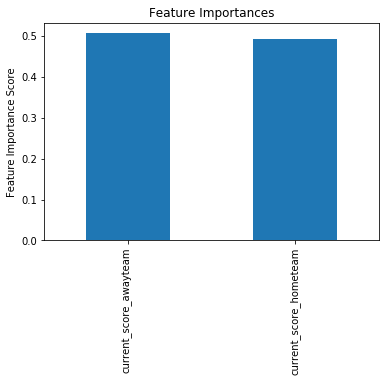

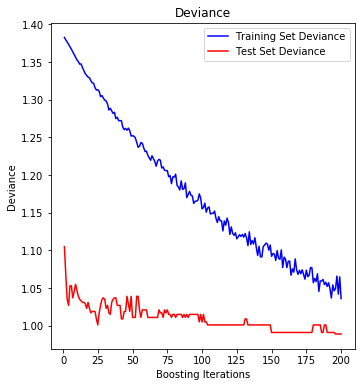

None

{'r2': 0.018905407825959508,
 'rmse': 0.4909175083453431,
 'feature_importances': array([0.49305288, 0.50694712]),
 'accuracy': 0.759,
 'accuracy_types': {'values': {'tn': 335, 'fp': 99, 'fn': 142, 'tp': 424},
  'rates': {'tnr': 0.771889400921659,
   'fpr': 0.22811059907834103,
   'fnr': 0.2508833922261484,
   'tpr': 0.7491166077738516}},
 'alg': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.005, loss='deviance', max_depth=10,
                            max_features='sqrt', max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=7,
                            min_weight_fraction_leaf=0.0, n_estimators=200,
                            n_iter_no_change=None, presort='auto',
                            random_state=None, subsample=0.8, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
       

In [11]:
# df_train_slice = create_game_minute_slice(df_train,alg_suite['period'],alg_suite['minutes_remaining'])
model_features_dict_defaults = modelfit(model_default, df_train, predictors, target)
model_features_dict_defaults

In [13]:
# Add Info about model to the "alg suite"
alg_suite['alg_default'] = model_features_dict_defaults
alg_suite['training_set_length']= len(df_train)
alg_suite


{'tag': 'alg_fiba_europe_winner_p1m3_v1_somepredictors',
 'description': 'Classification. Prediction if hometeam wins match. for period 1 minute 3.',
 'period': 1,
 'minutes_remaining': 3,
 'target': 'winner_hometeam',
 'target_is_binary': True,
 'predictors': ['current_score_hometeam', 'current_score_awayteam'],
 'alg_default': {'r2': 0.018905407825959508,
  'rmse': 0.4909175083453431,
  'feature_importances': array([0.49305288, 0.50694712]),
  'accuracy': 0.759,
  'accuracy_types': {'values': {'tn': 335, 'fp': 99, 'fn': 142, 'tp': 424},
   'rates': {'tnr': 0.771889400921659,
    'fpr': 0.22811059907834103,
    'fnr': 0.2508833922261484,
    'tpr': 0.7491166077738516}},
  'alg': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                             learning_rate=0.005, loss='deviance', max_depth=10,
                             max_features='sqrt', max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
              

## Test Alg No. 1 - 

* Test alg on test dataset
* Record results (add them to alg_suite)

In [26]:
def score_predictions_on_test_set(test_number,alg,target,period,minutes_remaining,predictors,target_is_binary):
    """Function for testing the alg against a "test set"
  
    Args:
        test_number (integer): number specifying which test it is (i.e. test "1","2","3" etc)
        alg: Gradient Boosting alg
        target (str): target field for which we are predicting.
        predictors (array[str]): fields we will use to predict for the target
        target_is_binary (boolean): whether or not the target is binary (i.e. a classification problem)
. So far, it always is "True"

    Returns:
        JSON blob with details about model accuracy

    """

    # retrieve the test dataset
    df_test = pd.read_pickle('fiba_europe_example/sample_test_data_male_adult_p1m3_slice.pickle')
    print("Retrieved Test Set")
    print("Length: " + str(len(df_test)))
    print("Unique Matches: " + str(len(df_test.match_id.unique())))
#     df_test = create_game_minute_slice(df_test,period,minutes_remaining)

    test_set_predictors = df_test[predictors]
    test_set_target = df_test[target]

    predictions_test = alg.predict(test_set_predictors)


    if target_is_binary:
        accuracy = accuracy_score(test_set_target, predictions_test)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        tn, fp, fn, tp = confusion_matrix(test_set_target, predictions_test).ravel()

        tnr = (1.00 *tn)/( tn + fp )
        fpr = (1.00 *fp)/( fp + tn ) 
        fnr = (1.00 *fn)/( tp + fn ) 
        tpr = (1.00 *tp)/( tp + fn ) 
    else:
        accuracy = 0.0
        tnr = 0.0
        fpr = 0.0
        fnr = 0.0
        tpr = 0.0

    mse = mean_squared_error(test_set_target, predictions_test)
    rmse = sqrt(mse)
    r2 = r2_score(test_set_target, predictions_test)


    print(" ----- ")    
    print("True Positives: " + str(tp))
    print("False Positives: " + str(fp))
    print("True Negatives: " + str(tn))
    print("False Negatives: " + str(fn))


    print(" ----- ")
    TPR = tp/(tp+fn)
    print("Sensitivity, hit rate, recall, or true positive rate (TP/(TP+FN)): %.2f%%" % (TPR * 100.0))


    TNR = tn/(tn+fp) 
    print("Specificity or true negative rate (TN/(TN+FP)): %.2f%%" % (TNR * 100.0))


    PPV = tp/(tp+fp)
    print("Precision or positive predictive value (TP/(TP+FP)): %.2f%%" % (PPV * 100.0))

    NPV = tn/(tn+fn)
    print("Negative predictive value (TN/(TN+FN)): %.2f%%" % (NPV * 100.0))

    FPR = fp/(fp+tn)
    print("Fall out or false positive rate (FP/(FP+TN)): %.2f%%" % (FPR * 100.0))

    FNR = fn/(tp+fn)
    print("False negative rate (FN/(TP+FN)): %.2f%%" % (FNR * 100.0))

    FDR = fp/(tp+fp)
    print("False discovery rate (FP/(TP+FP)): %.2f%%" % (FDR * 100.0))

    ACC = (tp+tn)/(tp+fp+fn+tn)
    print("Overall accuracy ((TP+TN)/(TP+FP+FN+TN)): %.2f%%" % (ACC * 100.0))
    
    
    return [{
    'test_number': test_number,
    'test_set_length': len(df_test),
    'accuracy': accuracy,
    'rmse': rmse,
    'r2': r2,
    'accuracy_types':{'values':{
        'tn':tn,
    'fp':fp,
    'fn': fn,
    'tp': tp
    },'rates': {
        'tnr':tnr,
    'fpr':fpr,
    'fnr': fnr,
    'tpr': tpr
    }

  }

}]

 




In [28]:

# test the alg on a dataset, and add results to the "alg suite"
test_number = 1

print("-----Alg Test: #1------")
print("\nTesting Default Alg")
alg_test = alg_suite['alg_default']['alg']
alg_suite['alg_default']['tests'] = score_predictions_on_test_set(test_number,alg_test,alg_suite['target'],alg_suite['period'],alg_suite['minutes_remaining'],alg_suite['predictors'],alg_suite['target_is_binary'])




-----Alg Test: #1------

Testing Default Alg
Retrieved Test Set
Length: 1000
Unique Matches: 1000
Accuracy: 63.40%
 ----- 
True Positives: 372
False Positives: 176
True Negatives: 262
False Negatives: 190
 ----- 
Sensitivity, hit rate, recall, or true positive rate (TP/(TP+FN)): 66.19%
Specificity or true negative rate (TN/(TN+FP)): 59.82%
Precision or positive predictive value (TP/(TP+FP)): 67.88%
Negative predictive value (TN/(TN+FN)): 57.96%
Fall out or false positive rate (FP/(FP+TN)): 40.18%
False negative rate (FN/(TP+FN)): 33.81%
False discovery rate (FP/(TP+FP)): 32.12%
Overall accuracy ((TP+TN)/(TP+FP+FN+TN)): 63.40%


In [29]:
#Save the alg suite (alg, accuracy results, metadata, etc)

def save_as_pickled_object(obj, filepath):
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])

filepath = 'fiba_europe_example_algs/' + alg_suite['tag']
save_as_pickled_object(alg_suite,filepath)
print(alg_suite['tag'] + ' saved successfully')

alg_fiba_europe_winner_p1m3_v1_somepredictors saved successfully


### Now Let's Repeat the Process with Another Alg and Compare Results

#### Alg No. 2 - "Several Predictors"


Model Report (ALPHA: 0.5) - 
RMSE: 0.1612 (absolute distance from mean in units of target metric)
R2 Variance Score: 0.8958
Accuracy : 0.974


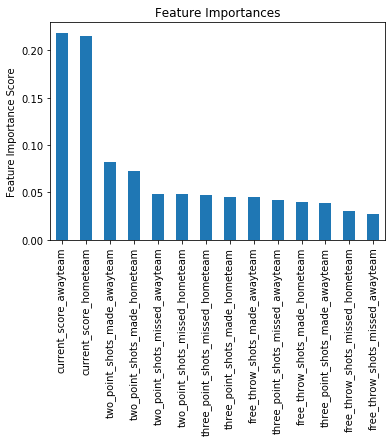

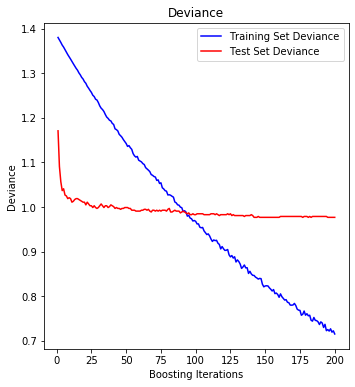

None

{'tag': 'alg_fiba_europe_winner_p1m3_v1_severalpredictors',
 'description': 'Classification. Prediction if hometeam wins match. for period 1 minute 3.',
 'period': 1,
 'minutes_remaining': 3,
 'target': 'winner_hometeam',
 'target_is_binary': True,
 'predictors': ['current_score_hometeam',
  'current_score_awayteam',
  'two_point_shots_made_hometeam',
  'two_point_shots_missed_hometeam',
  'three_point_shots_made_hometeam',
  'three_point_shots_missed_hometeam',
  'free_throw_shots_made_hometeam',
  'free_throw_shots_missed_hometeam',
  'two_point_shots_made_awayteam',
  'two_point_shots_missed_awayteam',
  'three_point_shots_made_awayteam',
  'three_point_shots_missed_awayteam',
  'free_throw_shots_made_awayteam',
  'free_throw_shots_missed_awayteam'],
 'alg_default': {'r2': 0.8957794693571598,
  'rmse': 0.161245154965971,
  'feature_importances': array([0.21484781, 0.21879678, 0.07291972, 0.04832555, 0.04547879,
         0.04740136, 0.03999031, 0.02981217, 0.08157916, 0.04855924,
   

In [30]:
# this one has more predictors
# Define predictors (features which we will use to predict an outcome)
predictors = ['current_score_hometeam',
  'current_score_awayteam',
  'two_point_shots_made_hometeam',
  'two_point_shots_missed_hometeam',
  'three_point_shots_made_hometeam',
  'three_point_shots_missed_hometeam',
  'free_throw_shots_made_hometeam',
  'free_throw_shots_missed_hometeam',
  'two_point_shots_made_awayteam',
  'two_point_shots_missed_awayteam',
  'three_point_shots_made_awayteam',
  'three_point_shots_missed_awayteam',
  'free_throw_shots_made_awayteam',
  'free_throw_shots_missed_awayteam']

# Create a dictionary with information about alg
# As the alg is created/tested, more info and results are added to this dictionary
# At the end, we can save the dictionary as a pickle object for subsequent retrieval
alg_suite = {
    'tag': 'alg_fiba_europe_winner_p1m3_v1_severalpredictors',
    'description':'Classification. Prediction if hometeam wins match. for period 1 minute 3.',
    'period':1,
    'minutes_remaining': 3,    
    'target': 'winner_hometeam',
    'target_is_binary':True,
    'predictors': predictors
}
model_features_dict_defaults = define_crude_default_hyper_params(df_train)
model_default = define_a_model(model_features_dict_defaults)

# fit the model
model_features_dict_defaults = modelfit(model_default, df_train, predictors, target)
model_features_dict_defaults

# Add Info about model to the "alg suite"
alg_suite['alg_default'] = model_features_dict_defaults
alg_suite['training_set_length']= len(df_train)
alg_suite



In [31]:

# test the alg on a dataset, and add results to the "alg suite"
test_number = 1

print("-----Alg Test: #1------")
print("\nTesting Default Alg")
alg_test = alg_suite['alg_default']['alg']
alg_suite['alg_default']['tests'] = score_predictions_on_test_set(test_number,alg_test,alg_suite['target'],alg_suite['period'],alg_suite['minutes_remaining'],alg_suite['predictors'],alg_suite['target_is_binary'])


-----Alg Test: #1------

Testing Default Alg
Retrieved Test Set
Length: 1000
Unique Matches: 1000
Accuracy: 66.90%
 ----- 
True Positives: 396
False Positives: 165
True Negatives: 273
False Negatives: 166
 ----- 
Sensitivity, hit rate, recall, or true positive rate (TP/(TP+FN)): 70.46%
Specificity or true negative rate (TN/(TN+FP)): 62.33%
Precision or positive predictive value (TP/(TP+FP)): 70.59%
Negative predictive value (TN/(TN+FN)): 62.19%
Fall out or false positive rate (FP/(FP+TN)): 37.67%
False negative rate (FN/(TP+FN)): 29.54%
False discovery rate (FP/(TP+FP)): 29.41%
Overall accuracy ((TP+TN)/(TP+FP+FN+TN)): 66.90%


In [32]:
# save the alg
filepath = alg_suite['tag']
save_as_pickled_object(alg_suite,filepath)
print(alg_suite['tag'] + ' saved successfully')

alg_fiba_europe_winner_p1m3_v1_severalpredictors saved successfully


In [ ]:
### Now Let's Repeat the Process once More and Compare Results

#### Alg No. 3 - "Too Many Predictors"


Model Report (ALPHA: 0.5) - 
RMSE: 0.0000 (absolute distance from mean in units of target metric)
R2 Variance Score: 1.0000
Accuracy : 1


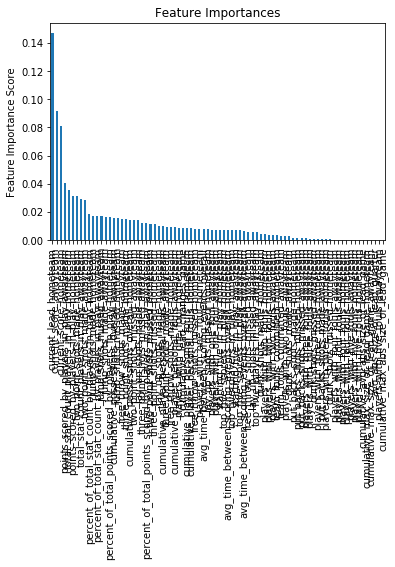

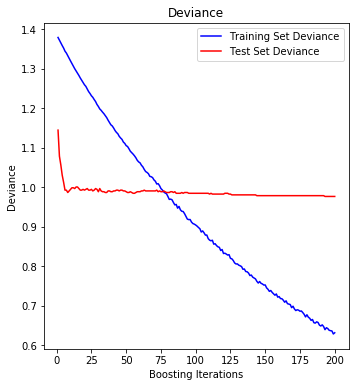

None

{'tag': 'alg_fiba_europe_winner_p1m3_v1_toomanypredictors',
 'description': 'Classification. Prediction if hometeam wins match. for period 1 minute 3.',
 'period': 1,
 'minutes_remaining': 3,
 'target': 'winner_hometeam',
 'target_is_binary': True,
 'predictors': ['current_score_hometeam',
  'current_score_awayteam',
  'team_fouls_committed_hometeam',
  'team_fouls_committed_awayteam',
  'avg_time_between_scoring_events_overall_hometeam',
  'avg_time_between_scoring_events_overall_awayteam',
  'avg_time_between_scoring_events_overall',
  'current_lead_hometeam',
  'cumulative_lead_changes_game',
  'cumulative_avg_abs_size_of_lead_game',
  'cumulative_max_abs_size_of_lead_game',
  'cumulative_max_size_of_lead_game_hometeam',
  'cumulative_max_size_of_lead_game_awayteam',
  'avg_abs_size_of_lead_quarter',
  'cumulative_possessions_overall_hometeam',
  'cumulative_possessions_overall_awayteam',
  'starting_five_in_play_hometeam',
  'starting_five_in_play_awayteam',
  'top_five_scorers_in_

In [33]:
# this one has more predictors
# Define predictors (features which we will use to predict an outcome)
predictors = ['current_score_hometeam',
  'current_score_awayteam',
  'team_fouls_committed_hometeam',
  'team_fouls_committed_awayteam',
  'avg_time_between_scoring_events_overall_hometeam',
  'avg_time_between_scoring_events_overall_awayteam',
  'avg_time_between_scoring_events_overall',
  'current_lead_hometeam',
  'cumulative_lead_changes_game',
  'cumulative_avg_abs_size_of_lead_game',
  'cumulative_max_abs_size_of_lead_game',
  'cumulative_max_size_of_lead_game_hometeam',
  'cumulative_max_size_of_lead_game_awayteam',
  'avg_abs_size_of_lead_quarter',
  'cumulative_possessions_overall_hometeam',
  'cumulative_possessions_overall_awayteam',
  'starting_five_in_play_hometeam',
  'starting_five_in_play_awayteam',
  'top_five_scorers_in_play_hometeam',
  'top_five_scorers_in_play_awayteam',
  'percent_of_total_points_scored_by_players_in_play_awayteam',
  'percent_of_total_points_scored_by_players_in_play_hometeam',
  'points_scored_by_players_in_play_hometeam',
  'points_scored_by_players_in_play_awayteam',
  'top_five_players_in_play_hometeam',
  'top_five_players_in_play_awayteam',
  'total_stat_count_players_in_play_hometeam',
  'total_stat_count_players_in_play_awayteam',
  'percent_of_total_stat_count_by_players_in_play_hometeam',
  'percent_of_total_stat_count_by_players_in_play_awayteam',
  'cumulative_player_personal_fouls_hometeam',
  'cumulative_player_personal_fouls_awayteam',
  'players_with_one_foul_hometeam',
  'players_with_two_fouls_hometeam',
  'players_with_three_fouls_hometeam',
  'players_with_four_fouls_hometeam',
  'players_with_five_fouls_hometeam',
  'players_with_one_foul_awayteam',
  'players_with_two_fouls_awayteam',
  'players_with_three_fouls_awayteam',
  'players_with_four_fouls_awayteam',
  'players_with_five_fouls_awayteam',
  'cumulative_player_personal_fouls_hometeam',
  'cumulative_player_personal_fouls_awayteam',
  'players_with_one_foul_hometeam',
  'players_with_two_fouls_hometeam',
  'players_with_three_fouls_hometeam',
  'players_with_four_fouls_hometeam',
  'players_with_five_fouls_hometeam',
  'players_with_one_foul_awayteam',
  'players_with_two_fouls_awayteam',
  'players_with_three_fouls_awayteam',
  'players_with_four_fouls_awayteam',
  'players_with_five_fouls_awayteam',
  'two_point_shots_made_hometeam',
  'jump_shots_made_hometeam',
  'lay_up_shots_made_hometeam',
  'put_backs_shots_made_hometeam',
  'dunk_shots_made_hometeam',
  'two_point_shots_missed_hometeam',
  'jump_shots_missed_hometeam',
  'lay_up_shots_missed_hometeam',
  'put_backs_shots_missed_hometeam',
  'dunk_shots_missed_hometeam',
  'three_point_shots_made_hometeam',
  'three_point_shots_missed_hometeam',
  'free_throw_shots_made_hometeam',
  'free_throw_shots_missed_hometeam',
  'two_point_shots_made_awayteam',
  'jump_shots_made_awayteam',
  'lay_up_shots_made_awayteam',
  'put_backs_shots_made_awayteam',
  'dunk_shots_made_awayteam',
  'two_point_shots_missed_awayteam',
  'jump_shots_missed_awayteam',
  'lay_up_shots_missed_awayteam',
  'put_backs_shots_missed_awayteam',
  'dunk_shots_missed_awayteam',
  'three_point_shots_made_awayteam',
  'three_point_shots_missed_awayteam',
  'free_throw_shots_made_awayteam',
  'free_throw_shots_missed_awayteam']  

# Create a dictionary with information about alg
# As the alg is created/tested, more info and results are added to this dictionary
# At the end, we can save the dictionary as a pickle object for subsequent retrieval
alg_suite = {
    'tag': 'alg_fiba_europe_winner_p1m3_v1_toomanypredictors',
    'description':'Classification. Prediction if hometeam wins match. for period 1 minute 3.',
    'period':1,
    'minutes_remaining': 3,    
    'target': 'winner_hometeam',
    'target_is_binary':True,
    'predictors': predictors
}
model_features_dict_defaults = define_crude_default_hyper_params(df_train)
model_default = define_a_model(model_features_dict_defaults)

# fit the model
model_features_dict_defaults = modelfit(model_default, df_train, predictors, target)
model_features_dict_defaults

# Add Info about model to the "alg suite"
alg_suite['alg_default'] = model_features_dict_defaults
alg_suite['training_set_length']= len(df_train)
alg_suite



In [34]:

# test the alg on a dataset, and add results to the "alg suite"
test_number = 1

print("-----Alg Test: #1------")
print("\nTesting Default Alg")
alg_test = alg_suite['alg_default']['alg']
alg_suite['alg_default']['tests'] = score_predictions_on_test_set(test_number,alg_test,alg_suite['target'],alg_suite['period'],alg_suite['minutes_remaining'],alg_suite['predictors'],alg_suite['target_is_binary'])


-----Alg Test: #1------

Testing Default Alg
Retrieved Test Set
Length: 1000
Unique Matches: 1000
Accuracy: 67.10%
 ----- 
True Positives: 409
False Positives: 176
True Negatives: 262
False Negatives: 153
 ----- 
Sensitivity, hit rate, recall, or true positive rate (TP/(TP+FN)): 72.78%
Specificity or true negative rate (TN/(TN+FP)): 59.82%
Precision or positive predictive value (TP/(TP+FP)): 69.91%
Negative predictive value (TN/(TN+FN)): 63.13%
Fall out or false positive rate (FP/(FP+TN)): 40.18%
False negative rate (FN/(TP+FN)): 27.22%
False discovery rate (FP/(TP+FP)): 30.09%
Overall accuracy ((TP+TN)/(TP+FP+FN+TN)): 67.10%


In [35]:
# save the alg
filepath = alg_suite['tag']
save_as_pickled_object(alg_suite,filepath)
print(alg_suite['tag'] + ' saved successfully')

alg_fiba_europe_winner_p1m3_v1_toomanypredictors saved successfully


results for metric: accuracy
alg_fiba_europe_winner_p1m3_v1_somepredictors: 0.634
alg_fiba_europe_winner_p1m3_v1_severalpredictors: 0.669
alg_fiba_europe_winner_p1m3_v1_toomanypredictors: 0.671


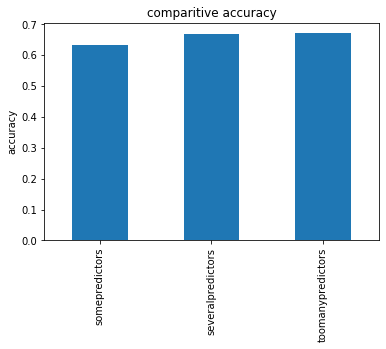

None

In [54]:
### Compare Results
import os
def try_to_load_as_pickled_object_or_None(filepath):
    max_bytes = 2**14 - 1
    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)
    except:
        return None
    return obj


# def show_test_results_for_alg_metric(algs,metric):
algs = [
    'alg_fiba_europe_winner_p1m3_v1_somepredictors',
    'alg_fiba_europe_winner_p1m3_v1_severalpredictors',
    'alg_fiba_europe_winner_p1m3_v1_toomanypredictors'
]

alg_tags = ['somepredictors','severalpredictors','toomanypredictors']

def display_test_comparisons(algs,alg_tags,test_metric):
    metric_results = []
    print("results for metric: " + test_metric)
    for alg in algs:
        alg_dictionary = try_to_load_as_pickled_object_or_None('fiba_europe_example_algs/' + alg)
        accuracy_values = alg_dictionary['alg_default']['tests'][0]['accuracy_types']['values']
        
        tp = accuracy_values['tp']
        tn = accuracy_values['tn']
        fp = accuracy_values['fp']
        fn = accuracy_values['fn']
        
        TPR = tp/(tp+fn)
        TNR = tn/(tn+fp) 
        PPV = tp/(tp+fp)
        NPV = tn/(tn+fn)
        FPR = fp/(fp+tn)
        FNR = fn/(tp+fn)
        FDR = fp/(tp+fp)
        ACC = (tp+tn)/(tp+fp+fn+tn)

        result_dict = {
            'accuracy':ACC,
            'true positive rate':TPR,
            'true negative rate':TNR,
            'positive predictive value':PPV,
            'negative predictive value':NPV,
            'false positive rate':FPR,
            'false negative rate':FNR,
            'false discovery rate':FDR
        }
        test_result = result_dict[test_metric]
        print(alg + ": " +  str(test_result))
        metric_results.append(test_result)
    plt.clf()
    results_plt = pd.Series(metric_results, alg_tags)
    results_plt.plot(kind='bar', title='comparitive ' + test_metric)
    plt.ylabel(test_metric)
    display(plt.show())
    

    
test_metric = 'accuracy'    
display_test_comparisons(algs,alg_tags,test_metric)

results for metric: true positive rate
alg_fiba_europe_winner_p1m3_v1_somepredictors: 0.6619217081850534
alg_fiba_europe_winner_p1m3_v1_severalpredictors: 0.7046263345195729
alg_fiba_europe_winner_p1m3_v1_toomanypredictors: 0.7277580071174378


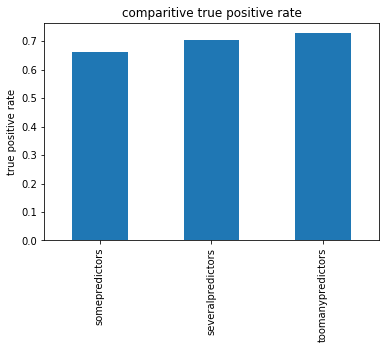

None

In [55]:
test_metric = 'true positive rate'    
display_test_comparisons(algs,alg_tags,test_metric)

results for metric: true negative rate
alg_fiba_europe_winner_p1m3_v1_somepredictors: 0.5981735159817352
alg_fiba_europe_winner_p1m3_v1_severalpredictors: 0.6232876712328768
alg_fiba_europe_winner_p1m3_v1_toomanypredictors: 0.5981735159817352


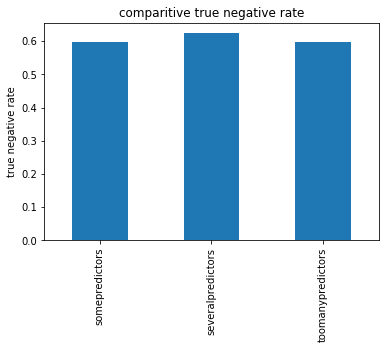

None

In [56]:
test_metric = 'true negative rate'    
display_test_comparisons(algs,alg_tags,test_metric)

results for metric: positive predictive value
alg_fiba_europe_winner_p1m3_v1_somepredictors: 0.6788321167883211
alg_fiba_europe_winner_p1m3_v1_severalpredictors: 0.7058823529411765
alg_fiba_europe_winner_p1m3_v1_toomanypredictors: 0.6991452991452991


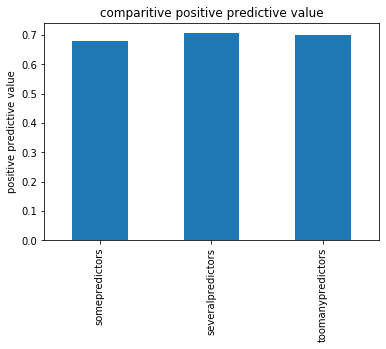

None

In [57]:
test_metric = 'positive predictive value'    
display_test_comparisons(algs,alg_tags,test_metric)

results for metric: negative predictive value
alg_fiba_europe_winner_p1m3_v1_somepredictors: 0.5796460176991151
alg_fiba_europe_winner_p1m3_v1_severalpredictors: 0.621867881548975
alg_fiba_europe_winner_p1m3_v1_toomanypredictors: 0.6313253012048192


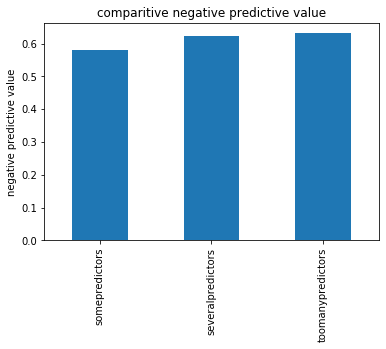

None

In [58]:
test_metric = 'negative predictive value'    
display_test_comparisons(algs,alg_tags,test_metric)

results for metric: false positive rate
alg_fiba_europe_winner_p1m3_v1_somepredictors: 0.4018264840182648
alg_fiba_europe_winner_p1m3_v1_severalpredictors: 0.3767123287671233
alg_fiba_europe_winner_p1m3_v1_toomanypredictors: 0.4018264840182648


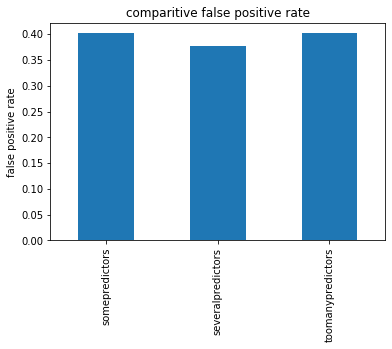

None

In [59]:
test_metric = 'false positive rate'    
display_test_comparisons(algs,alg_tags,test_metric)

results for metric: false negative rate
alg_fiba_europe_winner_p1m3_v1_somepredictors: 0.33807829181494664
alg_fiba_europe_winner_p1m3_v1_severalpredictors: 0.29537366548042704
alg_fiba_europe_winner_p1m3_v1_toomanypredictors: 0.2722419928825623


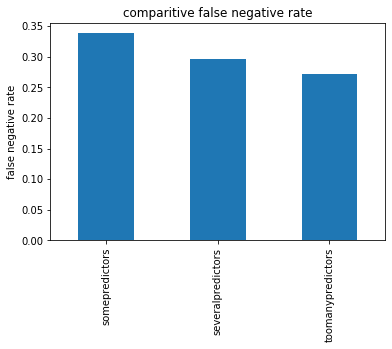

None

In [60]:
test_metric = 'false negative rate'    
display_test_comparisons(algs,alg_tags,test_metric)

results for metric: false discovery rate
alg_fiba_europe_winner_p1m3_v1_somepredictors: 0.32116788321167883
alg_fiba_europe_winner_p1m3_v1_severalpredictors: 0.29411764705882354
alg_fiba_europe_winner_p1m3_v1_toomanypredictors: 0.30085470085470084


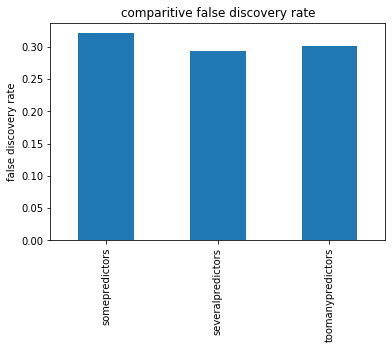

None

In [61]:
test_metric = 'false discovery rate'    
display_test_comparisons(algs,alg_tags,test_metric)